In [10]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import os


In [11]:
train_dir = r"F:\work\python\archive\classification_task\train"
test_dir = r"F:\work\python\archive\classification_task\test"

In [12]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 5000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


In [14]:
import numpy as np

# Count images per class
class_counts = np.bincount(train_generator.classes)

# Get class names
class_labels = list(train_generator.class_indices.keys())

# Print results
for i, count in enumerate(class_counts):
    print(f"{class_labels[i]}: {count} images")

glioma: 1147 images
meningioma: 1329 images
no_tumor: 1067 images
pituitary: 1457 images


In [15]:
class_counts_test = np.bincount(val_generator.classes)
class_labels_test = list(val_generator.class_indices.keys())

for i, count in enumerate(class_counts_test):
    print(f"{class_labels_test[i]}: {count} images")

glioma_tumor: 100 images
meningioma_tumor: 115 images
no_tumor: 105 images
pituitary_tumor: 74 images


In [16]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

# Fine-tune (since you now have large dataset)
base_model.trainable = True

# Freeze first few layers (optional but recommended)
for layer in base_model.layers[:15]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [17]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [18]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3
)


In [20]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=5,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 574s 4s/step - accuracy: 0.3760 - loss: 1.5985 - val_accuracy: 0.6790 - val_loss: 0.8280 - learning_rate: 1.0000e-05
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 551s 4s/step - accuracy: 0.5972 - loss: 0.9842 - val_accuracy: 0.7820 - val_loss: 0.5799 - learning_rate: 1.0000e-05
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1039s 7s/step - accuracy: 0.7072 - loss: 0.7612 - val_accuracy: 0.7980 - val_loss: 0.5274 - learning_rate: 1.0000e-05
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 601s 4s/step - accuracy: 0.7670 - loss: 0.6280 - val_accuracy: 0.8270 - val_loss: 0.4642 - learning_rate: 1.0000e-05
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 407s 3s/step - accuracy: 0.8078 - loss: 0.5312 - val_accuracy: 0.8480 - val_loss: 0.4194 - learning_rate: 1.0000e-05


In [21]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Overall Testing Accuracy: {:.2f}%".format(test_accuracy * 100))

32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8480 - loss: 0.4194
Overall Testing Accuracy: 84.80%


In [22]:
from sklearn.metrics import confusion_matrix, classification_report

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(test_generator.classes, y_pred))


32/32 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step
Confusion Matrix:
 [[174  70   0  10]
 [ 17 241  15  33]
 [  0   2 138   0]
 [  0   5   0 295]]

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.69      0.78       254
           1       0.76      0.79      0.77       306
           2       0.90      0.99      0.94       140
           3       0.87      0.98      0.92       300

    accuracy                           0.85      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.85      0.85      0.84      1000



32/32 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step


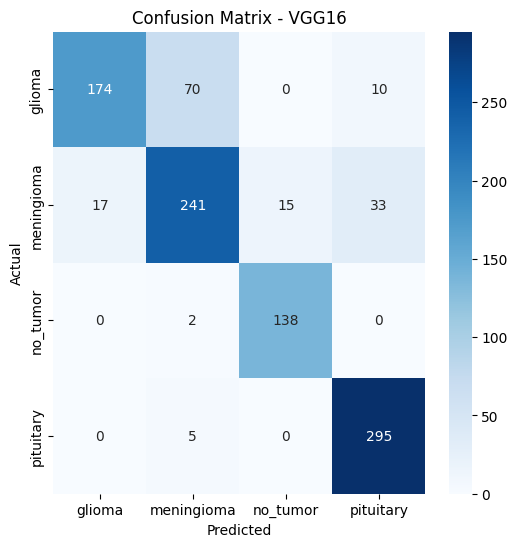

In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get predictions
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, 
            annot=True, 
            fmt="d", 
            cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - VGG16")
plt.show()
